Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
9
94
94
8836
Train on 400 samples, validate on 100 samples
Epoch 1/15
400/400 [==============================] - 12s 30ms/step - loss: 2.0769 - acc: 0.2650 - val_loss: 2.0088 - val_acc: 0.3000
Epoch 2/15
400/400 [==============================] - 11s 26ms/step - loss: 1.8600 - acc: 0.3600 - val_loss: 1.4799 - val_acc: 0.5600
Epoch 3/15
400/400 [==============================] - 11s 27ms/step - loss: 1.2814 - acc: 0.5800 - val_loss: 1.0570 - val_acc: 0.6600
Epoch 4/15
400/400 [==============================] - 11s 27ms/step - loss: 0.8111 - acc: 0.7400 - val_loss: 0.9953 - val_acc: 0.6500
Epoch 5/15
400/400 [==============================] - 11s 27ms/step - loss: 0.5864 - acc: 0.8325 - val_loss: 0.7399 - val_acc: 0.7300
Epoch 6/15
400/400 [==============================] - 11s 26ms/step - loss: 0.3715 - acc: 0.8700 - val_loss: 0.9108 - val_acc: 0.7600
Epoch 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


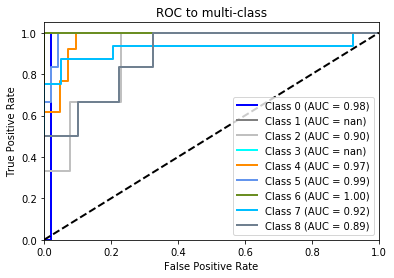

In [0]:
import keras
from keras.datasets import fashion_mnist 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras import optimizers


import numpy as np
import matplotlib.pyplot as plt
import csv

from os.path import join

ROOT = '/content/drive/'
PROJ = 'My Drive/Colab Notebooks/' # You need to change this parameter according to your real path.
DATA = 'My Drive/Colab Notebooks/unigram/Round10/' # You need to change this parameter according to your real path.

LEARNING_RATE = 0.001
EPOCHS = 15
MINI_BATCH = 10
DROPOUT_CONV = 0.5
#DROPOUT_HIDDEN = 0.6
FLATTEN_NODES = 256


PROJECT_PATH = join(ROOT, PROJ)
DATA_PATH = join(ROOT, DATA)

#First: mount the drive to access files 
from google.colab import drive
drive.mount(ROOT,force_remount=False)

from importlib.machinery import SourceFileLoader
data_helpers = SourceFileLoader('data_helpers', join(PROJECT_PATH, 'data_helpers_2.py')).load_module()

'''
Reading the dataset
'''
train_file = join(DATA_PATH,'train.csv')
test_file = join(DATA_PATH,'test.csv')

train_images, train_labels, test_images, test_labels, labels_count = data_helpers.load_training_and_testing_data(train_file,test_file)

#X1 = tf.reshape(X, [-1,image_width , image_height,1])

image_size = train_images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint32)
print(image_width)
print(image_height)
print(image_size)

train_images = train_images.reshape(-1, image_width, image_height, 1)

test_images = test_images.reshape(-1, image_width , image_height, 1)

model = Sequential()

model.add(Conv2D(32, (5,5), input_shape=(image_height, image_width, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_CONV))

model.add(Conv2D(64, (5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_CONV))

model.add(Conv2D(64, (5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_CONV))

model.add(Flatten())
model.add(Dense(FLATTEN_NODES))
model.add(Activation('relu'))

#=======================Old=======================
model.add(Dense(labels_count))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


history = model.fit(train_images, train_labels, validation_split=0.2, batch_size=MINI_BATCH, epochs=EPOCHS) #validation_split=0.1, 

#model.fit(train_X, train_Y_one_hot, batch_size=64, epochs=5)

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print('Test loss', test_loss)
print('Test accuracy', test_acc)

y_pred  = model.predict(test_images, batch_size=64, verbose=1)
size = y_pred.shape[0]



#==================================Display precision/recall================================

print(classification_report( np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

#==================================Display the ROC curvers==================================


n_classes = labels_count

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred[:, i])
    #print(test_labels[:, i])
    #print(y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this point
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)


colors = cycle(['blue','gray','silver','aqua', 'darkorange', 'cornflowerblue', 'olivedrab','deepskyblue','slategray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to multi-class')
plt.legend(loc="lower right")
plt.show()




#plt.imshow(test_X[0].reshape(28, 28), cmap = plt.cm.binary)
#plt.show()
